# Vehicle Detection and Tracking Project

The goals / steps of this project are the following:

- Get features of an image via Historgram of Oriented Gradients (HOG)
- (Optionally) Get additional features from spatial binning of color and from histograms of color
- Extract features
- Train a Support Vector Machine classifier via LinearSVC
- Use classifier to identify areas of an image that show a car
- Draw rectangles/boxes around areas that are identified as cars
- Search the lower part of an image (usually up to where cars can be expected i.e. not the sky) for cars
- Build a pipeline to perform the search and drawing of boxes
- Apply pipeline to a video stream

# Import all necessary libraries

In [1]:
# import all necessary libraries
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import glob
import time

%matplotlib inline

# Load training data (vehicles/non-vehicles)

In [2]:
# load training data (vehicles/non-vehicles)
car_data = glob.glob('data/vehicles/**/*.png')
noncar_data = glob.glob('data/non-vehicles/**/*.png')
print("There are %d car images and %d non-car images in the training set." % (len(car_data), len(noncar_data)))

There are 8792 car images and 8968 non-car images in the training set.


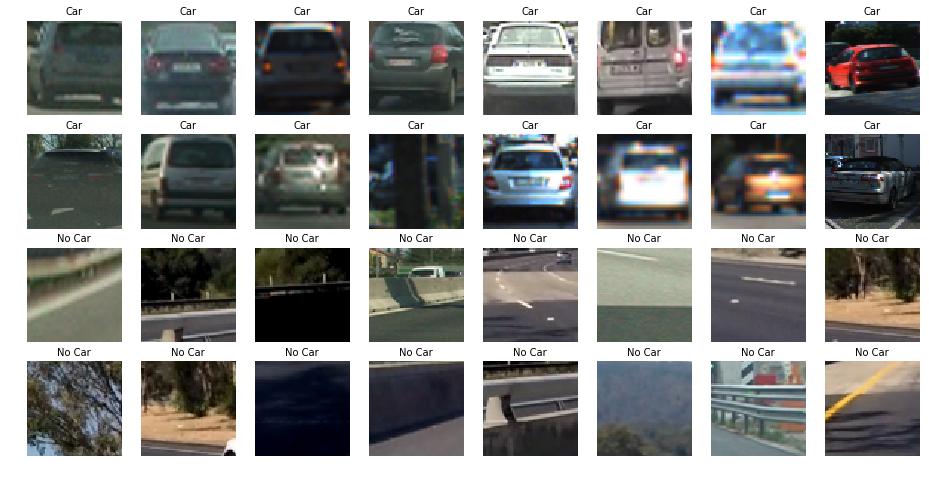

In [3]:
# visualize a subset of training data
f, ax1 = plt.subplots(4,8, figsize=(16,8))
ax1 = ax1.ravel()

# show car data
for i in np.arange(16):
    img = cv2.imread(car_data[np.random.randint(0, len(car_data))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax1[i].axis('off')
    ax1[i].set_title('Car', fontsize=10)
    ax1[i].imshow(img)

# show noncar data
for i in np.arange(16,32):
    img = cv2.imread(noncar_data[np.random.randint(0, len(noncar_data))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax1[i].axis('off')
    ax1[i].set_title('No Car', fontsize=10)
    ax1[i].imshow(img)

# Get histogram of oriented gradients (hog) features

In [4]:
# get histogram of oriented gradients (hog) features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

[ 0.09020405  0.02294796  0.0204329  ...,  0.01224961  0.01023739
  0.04246145]


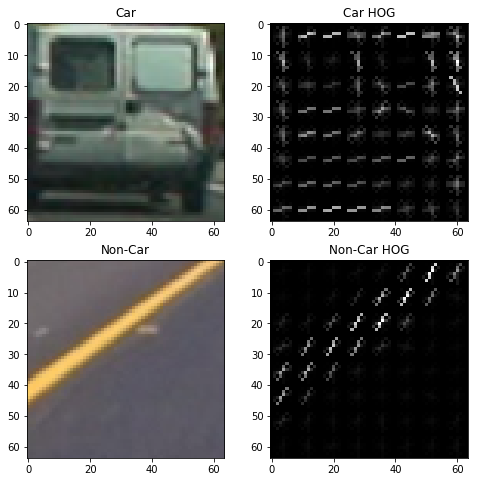

In [5]:
# visualize a subset of training data with HOG features
# config for get_hog_features()
orient = 9
pix_per_cell = 8
cell_per_block = 2

car_img = mpimg.imread(car_data[0])
noncar_img = mpimg.imread(noncar_data[0])

car_feat, car_hog = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
noncar_feat, noncar_hog = get_hog_features(noncar_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,8))

ax1.imshow(car_img)
ax1.set_title('Car')
ax2.imshow(car_hog, cmap='gray')
ax2.set_title('Car HOG')
ax3.imshow(noncar_img)
ax3.set_title('Non-Car')
ax4.imshow(noncar_hog, cmap='gray')
ax4.set_title('Non-Car HOG')

print(car_feat)

# Define Spatial Binning of Color and Histogram of Color functions  

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define function to extract HOG / Spatial Binning / Color Histogram features from array of images

In [7]:
# extract hog features from array of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0,256), 
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Apply features extraction to both car data and noncar data

In [8]:
# extract features for both car data and noncar data
# config
color_space = 'YCrCb' # from RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0,256)
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # from 0, 1, 2, or "ALL"
spatial_feat = True 
hist_feat = True
hog_feat = True


t = time.time()
car_feat = extract_features(car_data, color_space, spatial_size, hist_bins, hist_range, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
noncar_feat = extract_features(noncar_data, color_space, spatial_size, hist_bins, hist_range, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
t2 = time.time()

print('It took %d secs to extract spatial, color and HOG features.' % (round(t2-t, 2)))

X = np.vstack((car_feat, noncar_feat)).astype(np.float64)
print('vstack done')
X_scaler = StandardScaler().fit(X)
print('fit done')
scaled_X = X_scaler.transform(X)
print('transform done')

y = np.hstack( (np.ones(len(car_feat)), np.zeros(len(noncar_feat))) )
print('hstack done')

rand_state = np.random.randint(0, 100)
print('random done: %d' % (rand_state))

# split data set into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print('split done')

print('Using: %d orientations %d pixels per cell and %d cells per block' % (orient, pix_per_cell, cell_per_block))
print('Feature vector length:', len(X_train[0]))

It took 125 secs to extract spatial, color and HOG features.
vstack done
fit done
transform done
hstack done
random done: 39
split done
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


# Fit training set with LinearSVC

In [9]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print('It took %d secs to train the classifier.' % (round(t2-t, 2)))
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

It took 24 secs to train the classifier.
Test Accuracy of SVC =  0.9873
My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  0.  1.  0.  0.  0.]


# Define function to detect cars in an image

In [10]:
# support function for color conversions
def convert_color(img, conv='YCrCb'):
    # apply color conversion if other than 'RGB'
    if conv != 'RGB':
        if conv == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif conv == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif conv == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif conv == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif conv == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: return np.copy(img)

# detect car in image
def find_cars(img, ystart, ystop, color_space, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area=False):
    
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            # if search_area == True: will show all rectangles even if no cars detected (for presentation purposes)
            if test_prediction == 1 or search_area == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

# Define function to draw rectangles on image

In [11]:
# draw boxes onto image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

There are 12 rectangles with potential cars found in the image


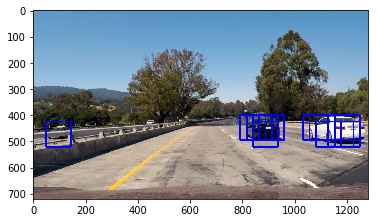

In [12]:
# visualize image with box
# config
ystart = 400
ystop = 656
scale = 1.5
    
img = mpimg.imread('test_images/test1.jpg')

rectangles = find_cars(img, ystart, ystop, color_space, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
annotated_img = draw_boxes(img, rectangles)

print('There are %d rectangles with potential cars found in the image' % (len(rectangles)))
plt.imshow(annotated_img)

# Show all boxes in various scales and locations as the program searches across the image

## At scale 1.0


There are 152 rectangles in the image


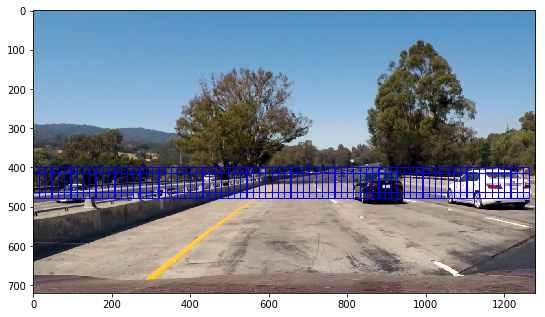

In [13]:
img = mpimg.imread('test_images/test1.jpg')

rects = []

ystart = 400
ystop = 480
scale = 1.0

rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area=True))
ystart = 416
ystop = 496
scale = 1.0

rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area=True))

rectangles = []
rectangles = [item for sublist in rects for item in sublist] 
annotated_img = draw_boxes(img, rectangles, color=(0,0,255), thick=2)
plt.figure(figsize=(9,9))
plt.imshow(annotated_img)
print('There are %d rectangles in the image' % (len(rectangles)))

## At scale 1.5

There are 98 rectangles in the image


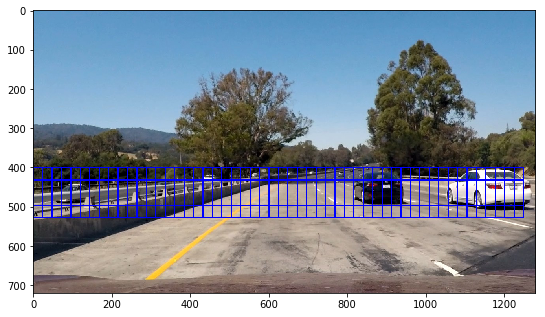

In [14]:
img = mpimg.imread('test_images/test1.jpg')

rects = []

ystart = 400
ystop = 528
scale = 1.5

rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area=True))
ystart = 432
ystop = 560
scale = 1.5

rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area=True))

rectangles = []
rectangles = [item for sublist in rects for item in sublist] 
annotated_img = draw_boxes(img, rectangles, color=(0,0,255), thick=2)
plt.figure(figsize=(9,9))
plt.imshow(annotated_img)
print('There are %d rectangles in the image' % (len(rectangles)))

## At scale 2.0

Number of boxes:  72


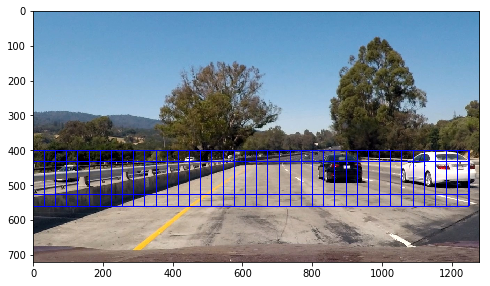

In [15]:
img = mpimg.imread('test_images/test1.jpg')

rects = []

ystart = 400
ystop = 560
scale = 2.0

rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area=True))
ystart = 432
ystop = 592
scale = 2.0

rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area=True))

rectangles = []
rectangles = [item for sublist in rects for item in sublist] 
annotated_img = draw_boxes(img, rectangles, color=(0,0,255), thick=2)
plt.figure(figsize=(9,9))
plt.imshow(annotated_img)
print('Number of boxes: ', len(rectangles))

## Combine all scales and show where cars are detected

Number of boxes:  15


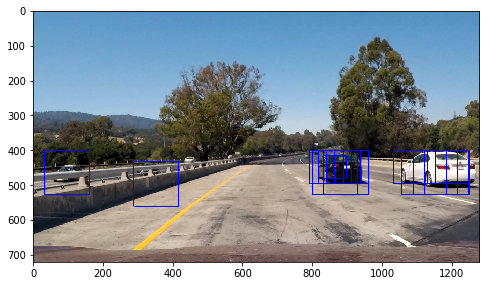

In [16]:
img = mpimg.imread('test_images/test1.jpg')

rects = []

search_area = False

ystart = 400
ystop = 480
scale = 1.0
rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area))
ystart = 416
ystop = 496
scale = 1.0
rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area))
ystart = 400
ystop = 528
scale = 1.5
rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area))
ystart = 432
ystop = 560
scale = 1.5
rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area))
ystart = 400
ystop = 560
scale = 2.0
rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area))
ystart = 432
ystop = 592
scale = 2.0
rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area))
ystart = 400
ystop = 592
scale = 3.5
rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area))
ystart = 464
ystop = 660
scale = 3.5
rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, search_area))


rectangles = []
rectangles = [item for sublist in rects for item in sublist] 
annotated_img = draw_boxes(img, rectangles, color=(0,0,255), thick=2)
plt.figure(figsize=(8,8))
plt.imshow(annotated_img)
print('Number of boxes: ', len(rectangles))

# Define the heatmap functions

In [17]:
# add heat
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [18]:
# apply threshold
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [19]:
# draw labeled boxes
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

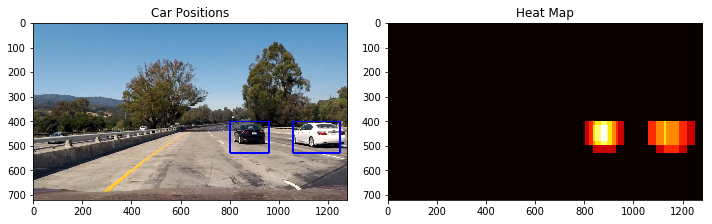

In [20]:
# draw boxes on image
img = mpimg.imread('test_images/test1.jpg')
heat = np.zeros_like(img[:,:,0])

# Add heat to each box in box list
heat = add_heat(heat, rectangles)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
annotated_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(annotated_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

# Define a function for searching through the frames from a video feed

In [62]:
# process frame for video
def process(img, show_heat=False):
    rects = []

    ystart = 400
    ystop = 480
    scale = 1.0
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 416
    ystop = 496
    scale = 1.0
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 528
    scale = 1.5
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 432
    ystop = 560
    scale = 1.5
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 560
    scale = 2.0
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 432
    ystop = 592
    scale = 2.0
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 592
    scale = 3.5
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 464
    ystop = 660
    scale = 3.5
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    rectangles = [item for sublist in rects for item in sublist] 
    
    heat = np.zeros_like(img[:,:,0])
    heat = add_heat(heat,rectangles)
    heat = apply_threshold(heat,1) 
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    annotated_img = draw_labeled_bboxes(np.copy(img), labels)
    
    if show_heat == True:
        return annotated_img, heatmap
    else:
        return annotated_img

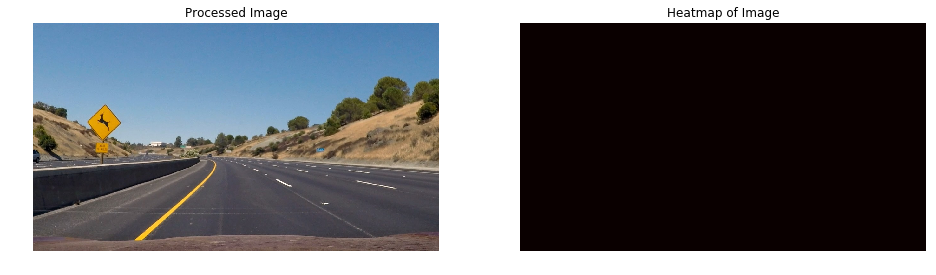

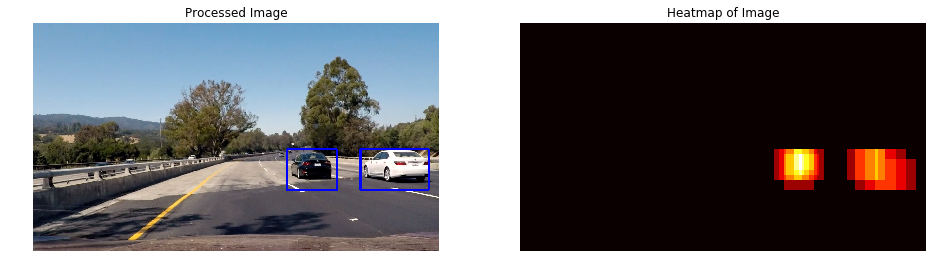

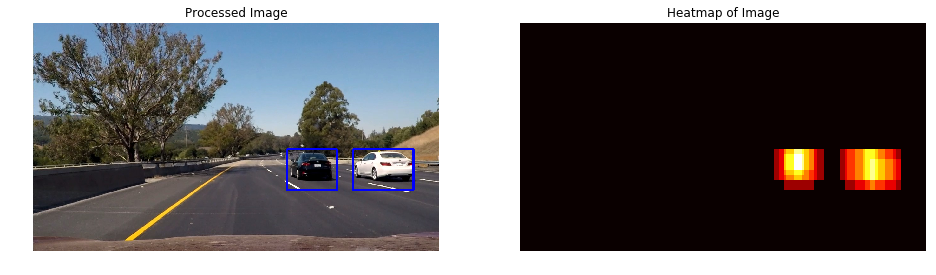

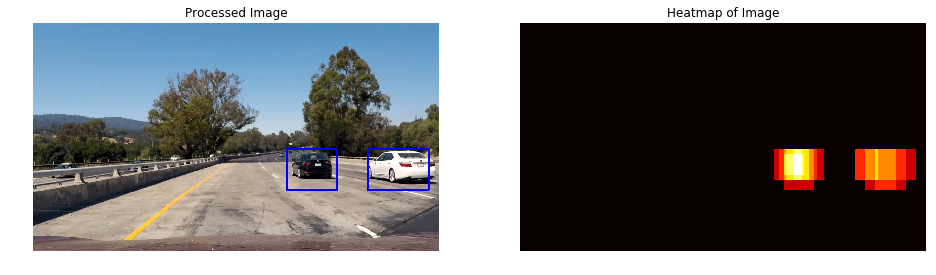

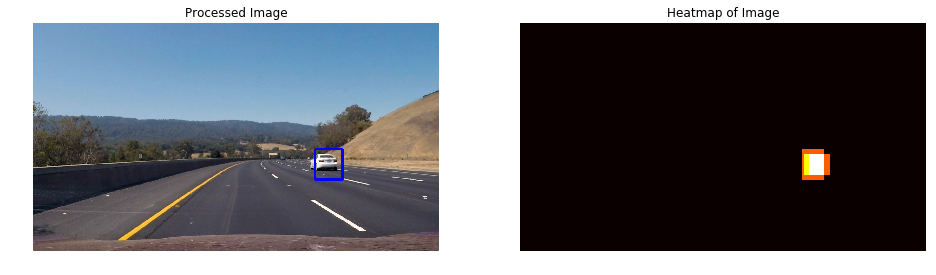

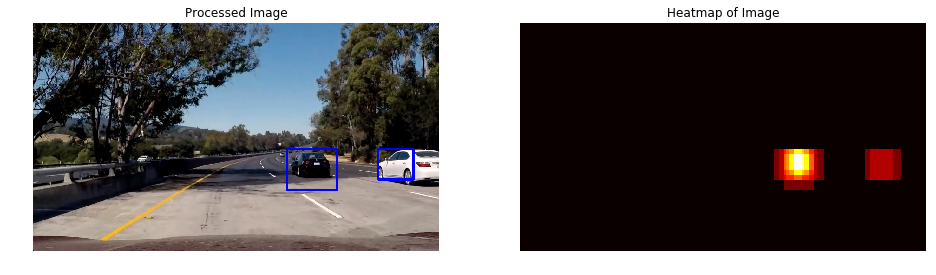

In [63]:
test_images = glob.glob('./test_images/test*.jpg')

for img in test_images:
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(16,14))
    img = mpimg.imread(img)
    processed_img, heatmap = process(img, show_heat=True)
    ax1.imshow(processed_img)
    ax1.axis('off')
    ax1.set_title('Processed Image')
    ax2.imshow(heatmap, cmap='hot')
    ax2.axis('off')
    ax2.set_title('Heatmap of Image')

In [64]:
# run through video
result = 'result.mp4'
clip = VideoFileClip('project_video.mp4')
clip_result = clip.fl_image(process)
%time clip_result.write_videofile(result, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [18:40<00:00,  1.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 22min 37s, sys: 4.37 s, total: 22min 41s
Wall time: 18min 41s


# Define a better function to search and record previously found car locations

In [66]:
# record past rectangles from video frames
class Vehicle():
    def __init__(self):
        self.previous_rectangles = []
    
    def add_rectangles(self, rectangles):
        self.previous_rectangles.append(rectangles)
        if len(self.previous_rectangles) > 15:
            self.previous_rectangles = self.previous_rectangles[len(self.previous_rectangles)-15:]

In [67]:
# process frame for video
def process_better(img):

    rects = []

    ystart = 400
    ystop = 480
    scale = 1.0
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 416
    ystop = 496
    scale = 1.0
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 528
    scale = 1.5
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 432
    ystop = 560
    scale = 1.5
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 560
    scale = 2.0
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 432
    ystop = 592
    scale = 2.0
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 400
    ystop = 592
    scale = 3.5
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    ystart = 464
    ystop = 660
    scale = 3.5
    rects.append(find_cars(img, ystart, ystop, color_space, scale, svc, 
                           X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    rectangles = [item for sublist in rects for item in sublist] 
    
    if len(rectangles) > 0:
        vehicle.add_rectangles(rectangles)
    
    heat = np.zeros_like(img[:,:,0])
    for past_rects in vehicle.previous_rectangles:
        heat = add_heat(heat, past_rects)
        
    new_threshold = 1 + len(vehicle.previous_rectangles)//2
    heat = apply_threshold(heat, 1 + len(vehicle.previous_rectangles)//2) 

    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    annotated_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return annotated_img

In [ ]:
vehicle = Vehicle()

result_2 = 'result_2.mp4'
clip_2 = VideoFileClip('project_video.mp4')
clip_result_2 = clip_2.fl_image(process_better)
%time clip_result_2.write_videofile(result_2, audio=False)

[MoviePy] >>>> Building video result_2.mp4
[MoviePy] Writing video result_2.mp4


 97%|█████████▋| 1229/1261 [18:07<00:28,  1.14it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(result_2))